##  Modeling the Impact of LAI paramter values on simulation of below canopy shortwave radiation in the Reynolds Mountain East catchment using pySUMMA

## 1. Introduction

One part of the Clark et al. (2015) study explored the impact of the choice of model parameter values on simulations of below canopy shortwave radiation at the aspen site in the Reynolds Mountain East catchment. This study looked at the impact of the Leaf Area Index[1.00, 1.25, 1.50, 1.75, 2.00] as used in the parameterization described by Mahat and Tarboton [2012] - UEB_2stream method(Mahat and Tarboton, WRR 2011:MT 2012)

In this Jupyter Notebook, the pySUMMA library is used to reproduce this analysis. According to the application of different Leaf Area Index [1.00, 1.25, 1.50, 1.75, 2.00], the sensitivity of result describes. 
The Results section shows how to use pySUMMA and the Pandas library to reproduce Figure 1(below) from Clark et al. (2015). 

Collectively, this Jupyter Notebook serves as an example of how hydrologic modeling can be conducted directly within a Jupyter Notebook by leveraging the pySUMMA library. 

## 2. Background

### Transmission of shortwave radiation through the vegetation canopy available in SUMMA

An important source of predictive differences among hydrologic and land-surface models is the method used to simulate the transmission and attenuation of shortwave radiation through the vegetation canopy. The main inter-model differences stem from (i) the methods used to simulate radiation transmission through homogenous vegetation [Dickinson, 1983; Sellers, 1985; Nijssen and Lettenmaier, 1999; Mahat and Tarboton, 2012]; (ii) the methods used to parameterize the impact of the canopy gap fraction on grid-average shortwave radiation fluxes [Cescatti, 1997; Kucharik et al., 1999; Niu and Yang, 2004; Essery et al., 2008]; and (iii) the methods used to represent spatial variability in vegetation type [Koster and Suarez, 1992; Bonan et al., 2002]. In this paper the parameterizations of canopy shortwave radiation are restricted to radiation transmission through homogenous vegetation, as this approach is used in many existing models. Recent advances in modeling the impact of canopy heterogeneity on grid average fluxes [e.g., Essery et al., 2008] are not included at this stage in model development, and will be considered in future work.

The methods considered for radiation transmission through homogenous vegetation allow for different levels of model complexity. At the simplest level we include an application of Beer’s Law for direct-beam radiation (e.g., as used in VIC). At a more complex level, we include methods that model direct and diffuse beams separately and account for multiple scattering and multiple reflections [Nijssen and Lettenmaier, 1999]. Building additional complexity, we also include options for two-stream radiative transfer models as implemented in UEB [Mahat and Tarboton, 2012] and the Noah-MP model and CLM [Dickinson, 1983; Sellers, 1985; Oleson et al., 2010; Niu et al., 2011].

### Two-stream radiative transfer models (UEB_2stream method, Mahat and Tarboton, 2012)

Mahat and Tarboton [2012] describe a two stream radiative transfer model based on the assumptions that radiation is scattered equally in an upward and downward direction and that scattering is along the same path as the incoming radiation. These assumptions yield

\begin{equation*}
- \frac{dU_{sw}}{dz} = \frac{G\eta_{l}}{cos({\theta}_{zen})}[-U_{sw} + \alpha_{leaf} \frac{U_{sw}+Q_{sw}}{2}]      \mspace{200mu}           (14)    
\end{equation*}

\begin{equation*}
- \frac{dQ_{sw}}{dz} = \frac{G\eta_{l}}{cos({\theta}_{zen})}[-Q_{sw} + \alpha_{leaf} \frac{U_{sw}+Q_{sw}}{2}]      \mspace{200mu}           (15)    
\end{equation*}

where $\alpha_{leaf}$  (-) is the leaf scattering coefficient, distinguished from the bulk canopy albedo used in equation (5) and (11), and $U_{sw}$ and $Q_{sw}$ $(W {m}^{-2})$ are the intensity of the upward and downward beams.
The solution for transmission over an infinitely deep canopy is [Mahat and Tarboton, 2012]

\begin{equation*}
\tau_{deep,b} = \frac{Q_{swb}(D_{can})} {Q_{swb}^{0}} = exp(-k^{'}G\frac{V_{ex}}{cos{\theta}_{zen}}) \mspace{200mu}           (16)
\end{equation*}

\begin{equation*}
\tau_{deep,d} = \frac{Q_{swd}(D_{can})} {Q_{swd}^{0}} = (1-k^{'}GV_{ex})exp(-k^{'}GV_{ex})+(k^{'}GV_{ex})^2E_{i}(1,k^{'}GV_{ex}) \mspace{200mu}           (17)
\end{equation*}

where $ k^{'} = \sqrt{1-\alpha_{leaf}} $ Equations (16) and (17) are similar to the expressions in equations (3) and (8), except the factor $ k^{'}$ is included to account for the effects of multiple scattering. Recall that $V_{ex}={\eta_{l}}D_{can}$.

The upward reflection factor $\alpha_{deep}^{veg} $ giving the fraction of radiation reflected from a deep canopy with multiple scattering is

\begin{equation*}
\alpha_{deep}^{veg} = \frac{U_{sw}(z)}{Q_{sw}(z)} = \frac{1-k^{'}}{1+k^{'}}       \mspace{200mu}           (18)    
\end{equation*}

Mahat and Tarboton [2012] use the principle of superposition to derive solutions for a finite canopy, as

\begin{equation*}
\tau_{b} = \frac{Q_{swb}(D_{can})} {Q_{swb}^{0}} = \frac{\tau_{deep,b}[1-(\alpha_{deep}^{veg})^2]}{1-(\alpha_{deep}^{veg})^{2}(\tau_{deep,b})^2} \mspace{200mu}           (19)
\end{equation*}

\begin{equation*}
\alpha_{b}^{veg} = \frac{U_{swb}^{0}} {Q_{swb}^{0}} = \frac{\alpha_{deep}^{veg}[1-(\tau_{deep,b})^2]}{1-(\alpha_{deep}^{veg})^{2}(\tau_{deep,b})^2} \mspace{200mu}           (20)
\end{equation*}

where $\tau_{b}$ and $\alpha_{b}^{veg}$ define the transmittance and reflectance for direct-beam radiation. Equations (19) and (20) can also be used to obtain $\tau_{d}$ and $\alpha_{d}^{veg}$ by replacing the direct transmittance $\tau_{deep,b}$ with the diffuse transmittance $\tau_{deep,d}$ [Mahat and Tarboton, 2012].

The shortwave radiation flux absorbed by the vegetation canopy and the ground surface can now be given as (now distinguishing between direct and diffuse surface albedo, $\alpha_{b}^{sfc}$ and $\alpha_{d}^{sfc}$, as defined in the next section),

\begin{equation*}
Q_{swnet}^{veg} = [Q_{swb}^{0}(1-\tau_{b})(1-\alpha^{veg}_{b})+Q_{swd}^{0}(1-\tau_{d})(1-\alpha^{veg}_{d}] + (Q_{swb}^{0}\tau_{b}\alpha_{b}^{sfc}+Q_{swd}^{0}\tau_{d}\alpha_{d}^{sfc})m_{r}(1-\tau_{d}) \mspace{50mu}           (21)
\end{equation*}

\begin{equation*}
Q_{swnet}^{sfc} = [Q_{swb}^{0}\tau_{b}(1-\alpha^{sfc}_{b})+Q_{swd}^{0}(\tau_{d})(1-\alpha^{sfc}_{d})]m_{r} \mspace{200mu}           (22)
\end{equation*}

where $m_{r}$ is the multiple reflections factor as defined in equation (13) but computed using diffuse reflectances and defined as $m_{r} = [1-\alpha_{d}^{veg}\alpha_{d}^{sfc}(1-\tau_{d})]^{-1}$ . As in equation (11) it is assumed that all upward radiation is diffuse.

We also consider the two-stream radiative transfer model of Dickinson [1983] and Sellers [1985], as implemented in both the Community Land Model [Oleson et al., 2010] and the Noah-MP model [Niu et al., 2011]. In this approach fluxes are computed separately for visible and near-infra-red wavelengths. Complete algorithmic details are provided by Oleson et al. [2010] and are not repeated here.

The above description are taken from the Stomal Resistance Method section within the manual Structure for Unifying Multiple Modeling Alternatives (SUMMA), Version 1.0: Technical Description (April, 2015).

## 3. Methods

### 1) Install latest pySUMMA from GitHub (https://github.com/UW-Hydro/pysumma)

In [ ]:
# On CyberGIS-Jupyter for water, pySUMMA installed, so users don't need to install pySUMMA.
import sys
!{sys.executable} -m pip install git+https://github.com/UW-Hydro/pysumma.git@master --upgrade

### 2) Download SUMMA Model Instance from HydroShare

In [2]:
from pysumma import hydroshare_utils
import os

In [3]:
# Download SUMMA Model Instance from HydroShare
resource_id = 'f2b5f41844a84b11b9fceeca76c60860'
instance = hydroshare_utils.get_hs_resource(resource_id, os.getcwd())

Username: choi
Password for choi: ········


In [4]:
!cd {instance}/; chmod +x ./installTestCases_local.sh
!cd {instance}/; ./installTestCases_local.sh

TestCases installed


### 3) Study Area

#### The Reynolds Mountain East catchment is located in southwestern Idaho as shown in the figure below.

<img src="SummaModel_ReynoldsAspenStand_ShortwaveRadiation_LAI/data/gis/study_area.jpg" width="1000">

In [ ]:
import sys
!{sys.executable} -m pip install geoviews

Populating the interactive namespace from numpy and matplotlib


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
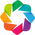

In [5]:
%pylab inline
import cartopy
import geoviews as gv
import holoviews as hv
hv.notebook_extension('bokeh')

In [6]:
shapefile = os.path.join(os.getcwd(), instance, "data/gis/Reynolds_Creek_watershed_wgs84.shp")
shapes = cartopy.io.shapereader.Reader(shapefile)
(gv.tile_sources.StamenTerrainRetina
 * gv.Shape.from_shapefile(shapefile, crs=cartopy.crs.PlateCarree(), value="LABLE", index="value").opts(
     style=dict(fill_color='honeydew', line_color='navy', alpha=0.5, cmap='Reds'))
).opts(width=900, height=500)

/opt/conda/envs/pysumma/lib/python3.8/site-packages/holoviews/plotting/util.py:685: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  [cmap for cmap in cm.cmap_d if not


:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]   (value)

### 4) Create pySUMMA Simulation Object

In [7]:
import pysumma as ps

In [8]:
instance = "SummaModel_ReynoldsAspenStand_ShortwaveRadiation_LAI"
executable = "/usr/bin/summa.exe"
executable

'/usr/bin/summa.exe'

In [9]:
# path to the SUMMA filemanager file
file_manager = os.path.join(os.getcwd(), instance, 'settings/summa_fileManager_riparianAspenVegParamPerturb.txt')
file_manager

'/home/jovyan/work/First_Paper/SummaModel_ReynoldsAspenStand_ShortwaveRadiation_LAI/settings/summa_fileManager_riparianAspenVegParamPerturb.txt'

In [10]:
# Create pySUMMA Simulation Object
S = ps.Simulation(executable, file_manager)

### 5) Run SUMMA for the different LAI parameter values

In [11]:
# check the simulation start and finish times
S.manager['simStartTime'].value, S.manager['simEndTime'].value

('2005-07-01 00:00', '2008-09-30 00:00')

#### 5-1) Check root Distribution Exponents

In [12]:
S.trial_params['summerLAI']

<xarray.DataArray 'summerLAI' (hru: 5)>
array([1.  , 1.25, 1.5 , 1.75, 2.  ])
Dimensions without coordinates: hru

#### 5.2) simulate SUMMA with the UEB_2stream method (Mahat and Tarboton, 2012)

In [13]:
S.decisions['canopySrad'] = 'UEB_2stream'
S.manager.write()
S.decisions['canopySrad'].value

'UEB_2stream'

In [14]:
S.run('local', run_suffix='_UEB_2stream')
results_UEB_2stream_ncfile = S.get_output_files()

## 4. Results

### Recreate the Figure 1(below) plot from Clark et al., 2015: The Impact of LAI parameter on the below canopy shortwave radiation of SUMMA Model at Reynolds Mountain East

In [16]:
from pysumma.plotting.plotting import Plotting
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

### 1) Create function to calculate below canopy shortwave radiation from SUMMA output

In [17]:
# get output netCDF and resample data by the average for hour of day
def calc_short_radiation(rad_output_df, start_time, end_time):
    # get 'solar radiation transmitted below the canopy' data from output netCDF, unit : Wm-2
    short_radiation_data = rad_output_df['scalarBelowCanopySolar']
    # create dates(X-axis) attribute from ouput netcdf
    dates = short_radiation_data.coords['time'].data
    # create data value(Y-axis) attribute from ouput netcdf
    data_values = short_radiation_data.data
    # create two dimensional tabular data structure 
    short_radiation_df = pd.DataFrame(data_values, index=dates)
    # round time to nearest hour (ex. 2006-10-01T00:59:59.99 -> 2006-10-01T01:00:00)
    short_radiation_df.index = short_radiation_df.index.round("H")
    # set the time period to display plot 
    short_radiation_df = short_radiation_df.loc[start_time:end_time] #"2006-07-01":"2007-09-30"
    # resample data by the average value hourly
    short_radiation_df_hourly = short_radiation_df.resample("H").mean()
    # resample data by the average for hour of day
    short_radiation_by_hour = short_radiation_df_hourly.groupby(short_radiation_df_hourly.index.hour).mean()
    return short_radiation_by_hour

### 2) Get hour of day output of the four below canopy shortwave radiation parameterization for the specific period (2005-10-01~2006-09-30)

In [18]:
results_UEB_2stream = xr.open_dataset(results_UEB_2stream_ncfile[0])
UEB_2stream_hour = calc_short_radiation(results_UEB_2stream, "2005-10-01", "2006-09-30")

In [19]:
UEB_2stream_LAI_1_00 = UEB_2stream_hour[0]
UEB_2stream_LAI_1_25 = UEB_2stream_hour[1]
UEB_2stream_LAI_1_50 = UEB_2stream_hour[2]
UEB_2stream_LAI_1_75 = UEB_2stream_hour[3]
UEB_2stream_LAI_2_00 = UEB_2stream_hour[4]

### 3) Create function to get below canopy shortwave radiation from forcing data

In [20]:
# get forcing netCDF and resample data by the average for hour of day
def calc_forcing(forcing_df, start_time, end_time):
    # get 'downward shortwave radiation at the upper boundary' data from forcing netCDF, unit : Wm-2
    forcing_data = forcing_df['SWRadAtm']
    # create dates(X-axis) attribute from ouput netcdf
    dates = forcing_data.coords['time'].data
    # create data value(Y-axis) attribute from ouput netcdf
    data_values = forcing_data.data
    # create two dimensional tabular data structure 
    total_forcing_df = pd.DataFrame(data_values, index=dates)
    # round time to nearest hour (ex. 2006-10-01T00:59:59.99 -> 2006-10-01T01:00:00)
    total_forcing_df.index = total_forcing_df.index.round("H")
    # set the time period to display plot 
    total_forcing_df = total_forcing_df.loc[start_time:end_time]
    # resample data by the average value hourly
    total_forcing_df_hourly = total_forcing_df.resample("H").mean()
    # resample data by the average for hour of day
    total_forcing_by_hour = total_forcing_df_hourly.groupby(total_forcing_df_hourly.index.hour).mean()
    return total_forcing_by_hour

### 4) Get hour of day forcing of the four below canopy shortwave radiation parameterizations for the specific period (2005-10-01~2006-09-30)

In [21]:
import xarray as xr
forcing_path =file_manager.split('/settings')[0]+'/data/forcingData/forcing_above_aspen.nc'
forcing = xr.open_dataset(forcing_path)

In [22]:
forcing_data = calc_forcing(forcing, "2005-10-01", "2006-09-30")

### 5) Combine the below canopy shortwave radiation parameterizations into a single Pandas Dataframe (2005-10-01~2006-09-30)

In [23]:
# Combine each below canopy shortwave radiation parameterizations
Radiation_Combine = pd.concat([forcing_data, UEB_2stream_LAI_1_00, UEB_2stream_LAI_1_25, UEB_2stream_LAI_1_50, UEB_2stream_LAI_1_75, UEB_2stream_LAI_2_00], axis=1)
# add label 
Radiation_Combine.columns = ["Above canopy forcing", "LAI = 1.00", "LAI = 1.25", "LAI = 1.50", "LAI = 1.75", "LAI = 2.00"]

In [24]:
Radiation_Combine

,Above canopy forcing,LAI = 1.00,LAI = 1.25,LAI = 1.50,LAI = 1.75,LAI = 2.00
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.868493,0.266894,0.235772,0.210224,0.188790,0.170544
7,31.739726,12.219209,10.824034,9.642653,8.629992,7.759439
8,112.805479,52.471320,47.491494,43.136688,39.299758,35.926724
9,229.090411,121.598172,112.397456,104.179359,96.759561,90.116069


### 6) Add obervation data from Aspen station and Reynolds Mountain East to the plot (2005-10-01~2006-09-30)

In [25]:
# create pySUMMA Plotting Object
Val_eddyFlux = Plotting(file_manager.split('/settings')[0]+'/data/validationData/ReynoldsCreek_eddyFlux.nc')

In [26]:
def obs_radiation(Val_eddyFlux, start_time, end_time):
    # read upward solar radiation from CNR 1(rsd) from validation netcdf file
    Obs_radiation = Val_eddyFlux.ds['rsd']
    # create dates(X-axis) attribute from validation netcdf file
    dates = Obs_radiation.coords['time'].data
    data_values = Obs_radiation.data  
    # create two dimensional tabular data structure 
    df = pd.DataFrame(data_values, index=dates)
    # set the time period to display plot
    df_filt = df.loc[start_time:end_time]
    # select aspen obervation station among three different stations
    df_filt.columns = ['Observation (aspen)','-','-']
    # resample data by the average for hour of day
    df_gp_hr = df_filt.groupby([df_filt.index.hour, df_filt.index.minute]).mean()
    # reset index so each row has an hour an minute column
    df_gp_hr.reset_index(inplace=True)
    # add hour and minute columns for plotting
    xvals = df_gp_hr.reset_index()['level_0'] + df_gp_hr.reset_index()['level_1']/60.
    return xvals, df_gp_hr

In [27]:
xvals, df_gp_hr = obs_radiation(Val_eddyFlux, "2005-10-01", "2006-09-30")

### 7) Plotting output of four different below canopy shortwave radiation parameterizations, forcing data and observation data (2005-10-01~2006-09-30)

(array([   0.,  200.,  400.,  600.,  800., 1000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

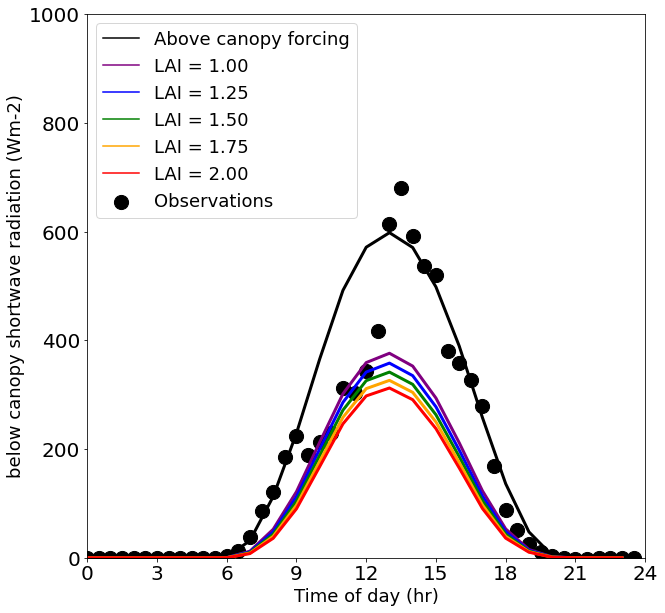

In [28]:
# create plot with four different below canopy shortwave radiation parameterizations
Radiation_Combine_Graph = Radiation_Combine.plot(legend=False,figsize=(10,10),color=['black', 'purple', 'blue', 'green', 'orange', 'red'])

Radiation_Combine_Graph.plot(Radiation_Combine['Above canopy forcing'], color='black', linewidth=3.0)
Radiation_Combine_Graph.plot(Radiation_Combine["LAI = 1.00"], color='purple', linewidth=3.0) 
Radiation_Combine_Graph.plot(Radiation_Combine['LAI = 1.25'], color='blue', linewidth=3.0)
Radiation_Combine_Graph.plot(Radiation_Combine['LAI = 1.50'], color='green', linewidth=3.0)
Radiation_Combine_Graph.plot(Radiation_Combine['LAI = 1.75'], color='orange', linewidth=3.0)
Radiation_Combine_Graph.plot(Radiation_Combine['LAI = 2.00'], color='red', linewidth=3.0)

Radiation_Combine_Graph.tick_params(labelsize = 15)
# plot scatter with x='xvals', y='Observation (aspen)'
d = Radiation_Combine_Graph.scatter(xvals, df_gp_hr['Observation (aspen)'], color='black', s=200, label="Observations")

# add x, y label
Radiation_Combine_Graph.set_xlabel("Time of day (hr)", fontsize=18)
Radiation_Combine_Graph.set_ylabel("below canopy shortwave radiation (Wm-2)", fontsize=18)

handles, labels = Radiation_Combine_Graph.get_legend_handles_labels()
# show up the legend
Radiation_Combine_Graph.legend(handles[0:7], labels[0:7], fontsize=18, loc=2)
plt.xlim(0,24)
plt.ylim(0,1000)
x = [0,3,6,9,12,15,18,21,24]
plt.xticks(x, x, fontsize=20)
plt.yticks(fontsize=20)

### 8) Get hour of day output of the four below canopy shortwave radiation parameterization for the specific period (2006-10-01~2007-09-30)

In [29]:
UEB_2stream_hour = calc_short_radiation(results_UEB_2stream, "2006-10-01", "2007-09-30")

In [30]:
UEB_2stream_LAI_1_00 = UEB_2stream_hour[0]
UEB_2stream_LAI_1_25 = UEB_2stream_hour[1]
UEB_2stream_LAI_1_50 = UEB_2stream_hour[2]
UEB_2stream_LAI_1_75 = UEB_2stream_hour[3]
UEB_2stream_LAI_2_00 = UEB_2stream_hour[4]
forcing_data = calc_forcing(forcing, "2006-10-01", "2007-09-30")

### 9) Combine the below canopy shortwave radiation parameterizations into a single Pandas Dataframe (2006-10-01~2007-09-30)

In [31]:
# Combine each below canopy shortwave radiation parameterizations
Radiation_Combine = pd.concat([forcing_data, UEB_2stream_LAI_1_00, UEB_2stream_LAI_1_25, UEB_2stream_LAI_1_50, UEB_2stream_LAI_1_75, UEB_2stream_LAI_2_00], axis=1)
# add label 
Radiation_Combine.columns = ["Above canopy forcing", "LAI = 1.00", "LAI = 1.25", "LAI = 1.50", "LAI = 1.75", "LAI = 2.00"]

### 10) Get hour of day forcing of the four below canopy shortwave radiation parameterizations for the specific period  (2006-10-01~2007-09-30)

In [32]:
xvals, df_gp_hr = obs_radiation(Val_eddyFlux, "2006-10-01", "2007-09-30")

### 11) Plotting output of four different below canopy shortwave radiation parameterizations, forcing data and observation data (2006-10-01~2007-09-30)

(array([   0.,  200.,  400.,  600.,  800., 1000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

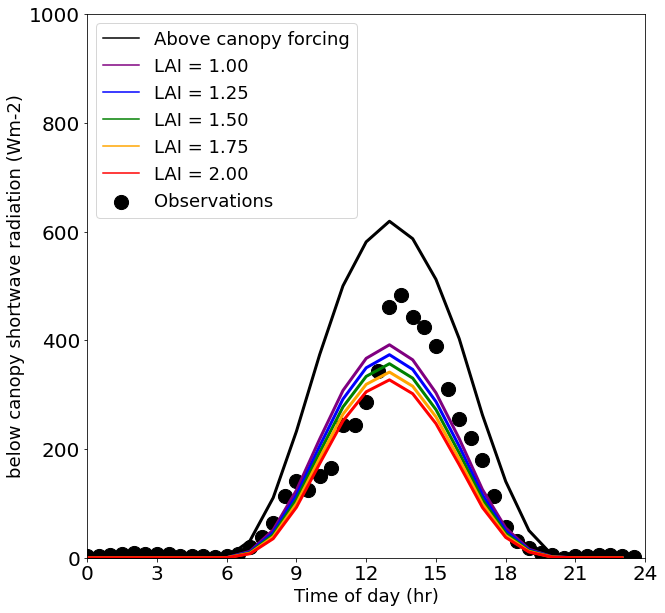

In [33]:
# create plot with four different below canopy shortwave radiation parameterizations
Radiation_Combine_Graph = Radiation_Combine.plot(legend=False,figsize=(10,10),color=['black', 'purple', 'blue', 'green', 'orange', 'red'])

Radiation_Combine_Graph.plot(Radiation_Combine['Above canopy forcing'], color='black', linewidth=3.0)
Radiation_Combine_Graph.plot(Radiation_Combine["LAI = 1.00"], color='purple', linewidth=3.0) 
Radiation_Combine_Graph.plot(Radiation_Combine['LAI = 1.25'], color='blue', linewidth=3.0)
Radiation_Combine_Graph.plot(Radiation_Combine['LAI = 1.50'], color='green', linewidth=3.0)
Radiation_Combine_Graph.plot(Radiation_Combine['LAI = 1.75'], color='orange', linewidth=3.0)
Radiation_Combine_Graph.plot(Radiation_Combine['LAI = 2.00'], color='red', linewidth=3.0)

Radiation_Combine_Graph.tick_params(labelsize = 15)
# plot scatter with x='xvals', y='Observation (aspen)'
d = Radiation_Combine_Graph.scatter(xvals, df_gp_hr['Observation (aspen)'], color='black', s=200, label="Observations")

# add x, y label
Radiation_Combine_Graph.set_xlabel("Time of day (hr)", fontsize=18)
Radiation_Combine_Graph.set_ylabel("below canopy shortwave radiation (Wm-2)", fontsize=18)

handles, labels = Radiation_Combine_Graph.get_legend_handles_labels()
# show up the legend
Radiation_Combine_Graph.legend(handles[0:7], labels[0:7], fontsize=18, loc=2)
plt.xlim(0,24)
plt.ylim(0,1000)
x = [0,3,6,9,12,15,18,21,24]
plt.xticks(x, x, fontsize=20)
plt.yticks(fontsize=20)

### 12) Get hour of day output of the four below canopy shortwave radiation parameterization for the specific period (2007-10-01~2008-09-30)

In [34]:
UEB_2stream_hour = calc_short_radiation(results_UEB_2stream, "2007-10-01", "2008-09-30")

In [35]:
UEB_2stream_LAI_1_00 = UEB_2stream_hour[0]
UEB_2stream_LAI_1_25 = UEB_2stream_hour[1]
UEB_2stream_LAI_1_50 = UEB_2stream_hour[2]
UEB_2stream_LAI_1_75 = UEB_2stream_hour[3]
UEB_2stream_LAI_2_00 = UEB_2stream_hour[4]
forcing_data = calc_forcing(forcing, "2007-10-01", "2008-09-30")

### 13) Combine the below canopy shortwave radiation parameterizations into a single Pandas Dataframe (2007-10-01~2008-09-30)

In [36]:
# Combine each below canopy shortwave radiation parameterizations
Radiation_Combine = pd.concat([forcing_data, UEB_2stream_LAI_1_00, UEB_2stream_LAI_1_25, UEB_2stream_LAI_1_50, UEB_2stream_LAI_1_75, UEB_2stream_LAI_2_00], axis=1)
# add label 
Radiation_Combine.columns = ["Above canopy forcing", "LAI = 1.00", "LAI = 1.25", "LAI = 1.50", "LAI = 1.75", "LAI = 2.00"]

### 14) Get hour of day forcing of the four below canopy shortwave radiation parameterizations for the specific period  (2007-07-01~2008-09-30)

In [37]:
xvals, df_gp_hr = obs_radiation(Val_eddyFlux, "2007-07-01", "2008-09-30")

### 15) Plotting output of four different below canopy shortwave radiation parameterizations, forcing data and observation data (2007-10-01~2008-09-30)

(array([   0.,  200.,  400.,  600.,  800., 1000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

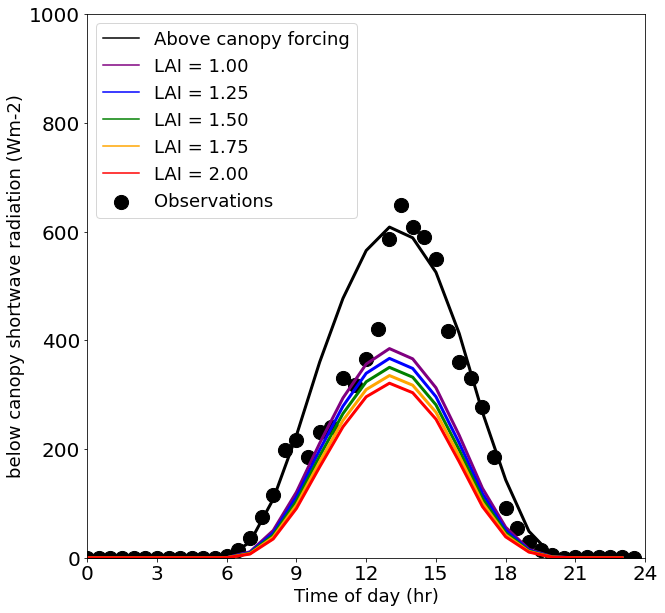

In [38]:
# create plot with four different below canopy shortwave radiation parameterizations
Radiation_Combine_Graph = Radiation_Combine.plot(legend=False,figsize=(10,10),color=['black', 'purple', 'blue', 'green', 'orange', 'red'])

Radiation_Combine_Graph.plot(Radiation_Combine['Above canopy forcing'], color='black', linewidth=3.0)
Radiation_Combine_Graph.plot(Radiation_Combine["LAI = 1.00"], color='purple', linewidth=3.0) 
Radiation_Combine_Graph.plot(Radiation_Combine['LAI = 1.25'], color='blue', linewidth=3.0)
Radiation_Combine_Graph.plot(Radiation_Combine['LAI = 1.50'], color='green', linewidth=3.0)
Radiation_Combine_Graph.plot(Radiation_Combine['LAI = 1.75'], color='orange', linewidth=3.0)
Radiation_Combine_Graph.plot(Radiation_Combine['LAI = 2.00'], color='red', linewidth=3.0)

Radiation_Combine_Graph.tick_params(labelsize = 15)
# plot scatter with x='xvals', y='Observation (aspen)'
d = Radiation_Combine_Graph.scatter(xvals, df_gp_hr['Observation (aspen)'], color='black', s=200, label="Observations")

# add x, y label
Radiation_Combine_Graph.set_xlabel("Time of day (hr)", fontsize=18)
Radiation_Combine_Graph.set_ylabel("below canopy shortwave radiation (Wm-2)", fontsize=18)

handles, labels = Radiation_Combine_Graph.get_legend_handles_labels()
# show up the legend
Radiation_Combine_Graph.legend(handles[0:7], labels[0:7], fontsize=18, loc=2)
plt.xlim(0,24)
plt.ylim(0,1000)
x = [0,3,6,9,12,15,18,21,24]
plt.xticks(x, x, fontsize=20)
plt.yticks(fontsize=20)

## 5. Discussion

As stated in Clark et al., 2015, the following insights can be gained from this analysis:
* This plotting compares the model simulations of downwelling shortwave radiation below the vegetation canopy with below-canopy shortwave radiation observations for the aspen site in Reynolds Mountain East. 
* The results in Figure 1 show that the choice of canopy shortwave parameterization with default parameters can result in differences in estimates of below-canopy shortwave radiation of around 50 W m22 at the Aspen site in Reynolds Mountain East

## 6. Post a new Model Instance, SUMMA output, and notebook back to Hydroshare

In [46]:
from pysumma.hydroshare import hydroshare
hs = hydroshare.hydroshare()

Successfully established a connection with HydroShare


In [48]:
# zip a renewal SUMMA Model Instance to upload on HydroShare
import shutil, os
archive_name = os.path.expanduser(os.path.join('~', os.getcwd() +'/' + instance +'_new'))
root_dir = os.path.expanduser(os.path.join('~', os.getcwd() +'/' + instance))
shutil.make_archive(archive_name, 'zip', root_dir)
Model_instance = os.getcwd() +'/' + instance +'_new.zip'

In [49]:
# set meta data such as abstract, title, keywords, rtype to create a new SUMMA Model Instance
title = 'Sensitivity to Below Canopy Shortwave Radiation Parameterization of SUMMA Model in Aspen stand at Reynolds Mountain East_LAI_new'
abstract = 'Sensitivity to Below Canopy Shortwave Radiation Parameterization of SUMMA Model in Aspen stand at Reynolds Mountain East_LAI(new)'
keywords = ('SUMMA', 'Hydrologic Model', 'Reynolds Mountain East', 'Below Canopy Shortwave Radiation Parameterization')
rtype = 'ModelInstanceResource'
fpath = Model_instance,
metadata = '[{"creator":{"name":"Youngdon Choi"}}, {"creator":{"name":"Jeffrey Sadler"}}]'
extra_metadata = '{"key-1": "value-1", "key-2": "value-2"}'

In [50]:
# create a new SUMMA Model Instance on HydroShare
resource_id1 = hs.createHydroShareResource(title=title, content_files=fpath, keywords=keywords, abstract=abstract, resource_type='modelinstanceresource', public=False)

Resource Created Successfully                           


In [51]:
# set meta data such as abstract, title, keywords, rtype to create a SUMMA Composite Resource that contains SUMMA Model instance, output, and notebook.
title = 'Sensitivity to Below Canopy Shortwave Radiation Parameterization of SUMMA Model in Aspen stand at Reynolds Mountain East_LAI_new'
abstract = 'Sensitivity to Below Canopy Shortwave Radiation Parameterization of SUMMA Model in Aspen stand at Reynolds Mountain East_LAI(new)'
keywords = ('SUMMA', 'Hydrologic Model', 'Reynolds Mountain East', 'Below Canopy Shortwave Radiation Parameterization')
rtype = 'CompositeResource'
files = out_file,
metadata = '[{"creator":{"name":"Youngdon Choi"}}, {"creator":{"name":"Jeffrey Sadler"}}]'
extra_metadata = '{"key-1": "value-1", "key-2": "value-2"}'

In [52]:
# create a new SUMMA Composite Resource on HydroShare
resource_id2 = hs.createHydroShareResource(title=title, content_files=files, keywords=keywords, abstract=abstract, resource_type='compositeresource', public=False)

Resource Created Successfully                           


In [53]:
# add a new SUMMA Model Instance to a new SUMMA Composite Resource.
hs.addContentToExistingResource(resource_id2, [Model_instance])

Successfully Added Content Files                      


#### Save this notebook file and add the notebook to the resource

In [54]:
# add a new notebook to a new SUMMA Composite Resource.
npath = os.getcwd() +'/SummaModel_ReynoldsAspenStand_ShortwaveRadiation_LAI_Figure1_Below.ipynb'
# check the resource id on HS that created.
hs.addContentToExistingResource(resource_id2, [npath])

Successfully Added Content Files                      
